# Fashion Image Classification on Maryland Polyvore: Third Scenario - FineTuning VGG19

## Authors
- Kamand Kalashi
- Sajjad Saed


## Project Overview
This project focuses on fine-tuning the VGG19 architecture to enhance image classification capabilities within the fashion domain. Our primary goal is to classify fashion images into distinct categories using the Maryland Fashion Dataset, which can be accessed [here](https://github.com/AemikaChow/AiDLab-fAshIon-Data/blob/main/Datasets/cleaned-maryland.md).

### Dataset
The Maryland Fashion Dataset consists of a diverse array of fashion images, organized into predefined classes. This variety allows the fine-tuned VGG19 model to effectively learn and generalize the visual features associated with different fashion items.

### Methodology
#### 1. Environment Setup
We start by importing essential libraries such as TensorFlow and Keras, which facilitate the building and training of the fine-tuning model. Additional libraries for data manipulation, image processing, and visualization are included to streamline the workflow.

#### 2. Data Preparation
Data preparation is crucial in any machine learning project. We mount Google Drive to access our dataset efficiently and retrieve class names, providing an overview of the categories we will work with. Sample images from each class are displayed to visualize the dataset's diversity.

#### 3. Image Preprocessing
To ensure effective processing by the VGG19 model, all images are resized to a uniform dimension of 150x150 pixels. Pixel values are also normalized to the [0, 1] range, which is essential for optimal training performance.

#### 4. Data Augmentation
To improve model robustness and mitigate overfitting, data augmentation techniques are applied. These include random rotations, shifts, and flips, which artificially increase the variability of the training dataset.

#### 5. Model Architecture
We utilize the pre-trained VGG19 model as our base architecture, initially setting its layers to non-trainable to retain the learned features from the ImageNet dataset. We then add a global average pooling layer, followed by dropout and dense layers, to classify the images into their respective categories.

#### 6. Model Compilation
The model is compiled using categorical crossentropy as the loss function and the Adam optimizer. Accuracy is monitored as the primary performance metric, providing insights into the model's classification capabilities.

#### 7. Model Training
The model is trained on the training dataset while the validation dataset allows for performance monitoring and overfitting prevention. We employ callbacks like EarlyStopping and ReduceLROnPlateau to optimize the training process.

#### 8. Model Evaluation
After training, the model's performance is evaluated on a separate test set. Metrics such as accuracy, loss, and a classification report (including precision, recall, and F1 scores for each class) are computed. A confusion matrix is visualized to identify misclassifications, aiding in further model refinement.


### Conclusion
This project demonstrates a comprehensive approach to fine-tuning the VGG19 model for image classification tasks. By following this structured methodology, we aim to develop a robust model capable of accurately classifying fashion images. Insights gained from the evaluation phase will inform future enhancements and iterations of the model.

## Importing Required Libraries
We import the necessary libraries for data processing, image manipulation, model building, and evaluation.

In [1]:
# Importing required libraries
# Feature extraction and feature selection
import numpy as np
import pandas as pd

# imqage processing and visualization
import cv2
import tqdm as tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Data training and create cnn model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.applications import VGG19
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, MaxPooling2D, GlobalAveragePooling2D, Flatten , BatchNormalization
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report
from keras.callbacks import EarlyStopping,ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import itertools
import ipywidgets as widgets

## Mounting Google Drive
To access the dataset stored on Google Drive, we mount it in our Colab environment.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset Path
We specify the path to the dataset in our Google Drive.

In [4]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Polyvore/'

## Getting Class Names
We define a function to retrieve the dataset class names and their count by listing the directories in the dataset path.

In [5]:
# return dataset class names and count
def get_class_names(data_path):
    class_names = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    return class_names

In [6]:
# get dataset class names and count
class_names = get_class_names(dataset_path)
print("Dataset class count:", len(class_names)," and names are:", class_names)

Dataset class count: 8  and names are: ['bag', 'dress', 'eyewear', 'hats', 'neckwear', 'pants', 'shoes', 'watches']


## Image Preprocessing
We resize all images to a uniform size (150x150) and store them along with their labels in an array.

In [7]:
# to resizing all data to same size (150*150)
image_size = 150
# Array to store all images with its label
all_data = []
image_count = []
count = 0

# For each index in the list of classes (class_names), by using method join with arguments dataset_path and i,
# reads all images of these classes and after resizing to 150*150, store the image with its label in all_data array
for i in class_names:
  path=os.path.join(dataset_path,i)
  class_label = class_names.index(i)
  for image in tqdm.tqdm(os.listdir(path)):
    try:
      image_array=cv2.imread(os.path.join(path,image))
      new_image_array = cv2.resize(image_array, (image_size, image_size))
      all_data.append([new_image_array, class_label])
      # plt.imshow(new_image_array)
      # plt.show()
      # break
      if os.path.isfile(os.path.join(path,image)):
        count += 1
    except Exception as e:
      pass
  image_count.append([count, class_names[class_label]])
  count = 0
image_count

100%|██████████| 786/786 [00:04<00:00, 194.09it/s]


[[786, 'bag'],
 [800, 'dress'],
 [780, 'eyewear'],
 [782, 'hats'],
 [791, 'neckwear'],
 [793, 'pants'],
 [789, 'shoes'],
 [786, 'watches']]

In [8]:
print(len(all_data))

6307


In [9]:
all_data[0][0].shape

(150, 150, 3)

## Converting Data to NumPy Array
We convert the image data to a NumPy array for easier processing and shuffle the data.

In [10]:
# split images and labels to X and Y arays
# images
labels = class_names
X = []
# labels
Y = []
for i, j in all_data:
  X.append(i)
  Y.append(j)

X = np.array(X)
X , Y = shuffle(X,Y,random_state = 42)
print(X.shape)
X = X /255
y_categorical = to_categorical(Y,num_classes = 8)

(6307, 150, 150, 3)


## Splitting the Data
We split the data into training and testing sets, ensuring that we have a balanced distribution of classes in both sets.

In [11]:
# split the all_data into 80% train data and 20% test data by random state 42
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size = 0.2, random_state = 101,shuffle = True)
# split 20% of the train data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 101,shuffle = True)

In [12]:
print('all data:', len(all_data))
print('total train data:', len(X_train) , 'and shape:', X_train.shape)
print('total validation data:', len(X_val), 'and shape:', X_val.shape)
print('total test data:', len(X_test), 'and shape:', X_test.shape)

all data: 6307
total train data: 4036 and shape: (4036, 150, 150, 3)
total validation data: 1009 and shape: (1009, 150, 150, 3)
total test data: 1262 and shape: (1262, 150, 150, 3)


In [13]:
# Data Preprocessing
train_generator = ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    featurewise_std_normalization=False,
    samplewise_center=False,
    samplewise_std_normalization=False,
    # rescale=1./255,  # Add rescaling
    # brightness_range=[0.5, 1.5],  # Random brightness
    # channel_shift_range=10.0,  # Random channel shift
    # preprocessing_function=tf.keras.applications.vgg.preprocess_input
)


# train_generator =ImageDataGenerator(  rotation_range=35,
#                                       width_shift_range=0.2,
#                                       height_shift_range=0.2,
#                                       horizontal_flip=True,
#                                       shear_range=0.2,
#                                       zoom_range=0.2,
#                                       featurewise_std_normalization=False,
#                                       samplewise_center=False,
#                                       samplewise_std_normalization=False,
#   # rotation_range=10,
#   # width_shift_range=0.2,
  # horizontal_flip=False,
  # vertical_flip=False,
  # zoom_range=0.2,
  # featurewise_center=False,
  # featurewise_std_normalization=False,
  # samplewise_center=False,
  # samplewise_std_normalization=False,
  # zca_whitening=False
  # )

## Defining the Model
We define the VGG19 model, excluding the top layers, and add our own layers for classification.

In [14]:
base_model = VGG19(weights = 'imagenet', include_top = False, input_shape = (image_size, image_size, 3))
for layer in base_model.layers:
    layer.trainable = False

In [15]:
#Sajjad
model = Sequential()
model = base_model.output
# # # Set the last few layers of the base model to be trainable
# for layer in base_model.layers[-3:]:
#     layer.trainable = True

# model = GlobalAveragePooling2D()(model)
# model = BatchNormalization()(model)
# # model = Dropout(rate = 0.2)(model)

# model= Dense(256, activation='relu')(model)
# model = Dropout(rate = 0.5)(model)
# # model = Dropout(rate = 0.2)(model)
# model = Dense(8, activation = 'softmax')(model)
# model = Model(inputs = base_model.input, outputs = model)

#Kami
model = GlobalAveragePooling2D()(model)
model = BatchNormalization()(model)
model = Dropout(rate = 0.5)(model)
model= Dense(64, activation='relu')(model)
model = Dropout(rate = 0.2)(model)
model = Dense(8, activation = 'softmax')(model)
model = Model(inputs = base_model.input, outputs = model)
# model.trainable = True

# Set the last few layers of the base model to be trainable
for layer in base_model.layers[-5:]:
    layer.trainable = True

# model = Flatten()(base_model.output)
# model = Dense(256, activation='relu')(model)
# model = Dropout(0.5)(model)
# model = Dense(10, activation='softmax')(model)
# model = Model(inputs = base_model.input, outputs = model)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ['accuracy'])

In [18]:
# Set up data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   horizontal_flip=True)

# Set up data augmentation for validation/test data
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 4, verbose = 1, min_delta = 0.0001)
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("DL_project_transfer_learning2.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')

## Model Training
We train the model on the training dataset with validation on the test dataset.

In [21]:
train_generator.fit(X_train)
vgg19_history = model.fit_generator(train_generator.flow(X_train, y_train, batch_size = 32),
                              epochs = 30,
                              validation_data = (X_val, y_val),
                              verbose = 1,
                              callbacks = [reduce_lr, tensorboard, checkpoint, ])

<ipython-input-21-ad4204412690>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg19_history = model.fit_generator(train_generator.flow(X_train, y_train, batch_size = 32),


Epoch 1/30
127/127 [==============================] - ETA: 0s - loss: 1.6699 - accuracy: 0.3707
Epoch 1: val_accuracy improved from -inf to 0.13181, saving model to DL_project_transfer_learning2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


127/127 [==============================] - 56s 362ms/step - loss: 1.6699 - accuracy: 0.3707 - val_loss: 13.6942 - val_accuracy: 0.1318 - lr: 0.0010
Epoch 2/30
127/127 [==============================] - ETA: 0s - loss: 1.1148 - accuracy: 0.5907
Epoch 2: val_accuracy improved from 0.13181 to 0.79584, saving model to DL_project_transfer_learning2.h5
127/127 [==============================] - 44s 345ms/step - loss: 1.1148 - accuracy: 0.5907 - val_loss: 0.6391 - val_accuracy: 0.7958 - lr: 0.0010
Epoch 3/30
127/127 [==============================] - ETA: 0s - loss: 0.7905 - accuracy: 0.7329
Epoch 3: val_accuracy did not improve from 0.79584
127/127 [==============================] - 34s 269ms/step - loss: 0.7905 - accuracy: 0.7329 - val_loss: 1.6106 - val_accuracy: 0.6174 - lr: 0.0010
Epoch 4/30
127/127 [==============================] - ETA: 0s - loss: 0.6060 - accuracy: 0.8070
Epoch 4: val_accuracy did not improve from 0.79584
127/127 [==============================] - 31s 246ms/step - los

In [22]:
# Save the Model
model.save('VGG19_Fine_Tuning.h5')

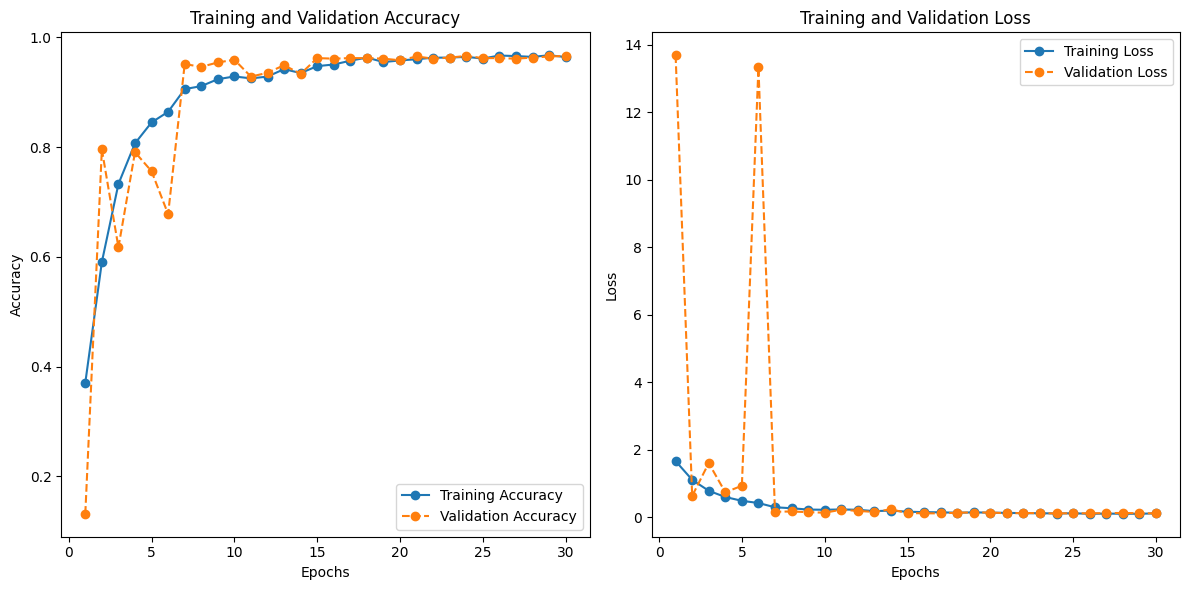

In [23]:
# Displaying curves of loss and accuracy during training
acc =vgg19_history.history['accuracy']
val_acc = vgg19_history.history['val_accuracy']
loss = vgg19_history.history['loss']
val_loss = vgg19_history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy on the left side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', linestyle='dashed')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss on the right side
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='dashed')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=vgg19_history.history['val_loss'], mode="lines+markers",
            marker=dict(
                symbol="circle",
                size=9,
                angleref="previous",
            ), name="Validation_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=vgg19_history.history['loss'], mode="lines+markers",
            marker=dict(
                symbol="circle",
                size=9,
                angleref="previous",
            ), name="Training_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=vgg19_history.history['val_accuracy'], mode="lines+markers",
            marker=dict(
                symbol="circle",
                size=9,
                angleref="previous",
            ), name="Validation_accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=vgg19_history.history['accuracy'], mode="lines+markers",
            marker=dict(
                symbol="circle",
                size=9,
                angleref="previous",
            ), name="Training_accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of CNN Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Loss</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Accuracy</b>", secondary_y=True)

fig.show()

## Model Evaluation
We evaluate the model on the test dataset and generate a classification report and confusion matrix.

In [ ]:
# Evaluate the model  --> first method
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_real = np.argmax(y_test, axis = 1)

# display result of evaluate the model  --> first method
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy: {:.2f}%".format(test_acc * 100))
print(f"Test loss: {test_loss: 0.2f}")

# display result of evaluate the model  --> first method
accuracy = np.sum(y_pred == y_real) / len(y_test)
print("Test accuracy: {:.2f}%".format(accuracy * 100))

40/40 [==============================] - 6s 135ms/step


In [ ]:
print(classification_report(y_real, y_pred, target_names=class_names))

## Confusion Matrix
We visualize the confusion matrix to understand the model's performance across different classes.

In [ ]:
# display confusion matrix
fig, ax = plt.subplots(1,1,figsize=(14, 6))
sns.heatmap(confusion_matrix(y_real, y_pred), xticklabels=class_names, yticklabels=class_names,annot=True, linewidths=2, linecolor='white', ax=ax)
fig.text(s="Confusion Matrix", size=18,fontweight='bold', fontname='DejaVu Sans', y=0.88,x=0.30,alpha=0.8)
bottom, top = plt.ylim()
plt.ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted', color='blue')
plt.ylabel('Real', color='green')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
# plt.show()

## Conclusion
In this project, we successfully fine-tuned the VGG19 model for fashion image classification. This approach allowed us to leverage the pre-trained model's features while adapting it to our specific dataset. The model demonstrated promising accuracy, and the evaluation metrics provide valuable insights into areas for further improvement and optimization.